# <center>**ĐỒ ÁN 2: IMAGE PROCESSING**</center>
### <center>**21127112 - Triệu Nhật Minh**</center>

### **Thư viện**

In [496]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### **0. Hiển thị danh sách ảnh**

In [497]:
def show_image(img_list):
    plt.figure(figsize=(20,15))
    size = len(img_list)
    if size == 2 or size == 3:
        [plt.subplot(1, size, i+1) and plt.imshow(img_list[i]) for i in range(size)]
    elif size == 12:
        [plt.subplot(3, 4, i+1) and plt.imshow(img_list[i]) for i in range(size)]
    plt.show()

### **1. Thay đổi độ sáng cho ảnh**

In [498]:
def limit_value(img_2d):
    return np.clip(img_2d, 0, 255, out=img_2d)

In [499]:
def change_brightness(img_2d, brightness=128):
    return limit_value(img_2d.astype('int64') + brightness).astype('uint8'), '_brightness_' + str(brightness)

### **2. Thay đổi độ tương phản của ảnh**

In [500]:
def change_contrast(img_2d, contrast=128):
    factor = (259 * (contrast + 255)) / (255 * (259 - contrast))
    return limit_value(factor * (img_2d.astype('float64') - 128) + 128).astype('uint8'), '_contrast_' + str(contrast)

### **3. Lật ảnh ngang/dọc**

In [501]:
def flip_image(img_2d, axis):
    if axis == 0:
        name = '_flip_vertical'
        return img_2d[::-1, :], name
    elif axis == 1:
        name = '_flip_horizontal'
        return img_2d[:, ::-1], name

### **4. RGB &rarr; grayscale, RGB &rarr; sepia**

In [502]:
def convert_grayscale(img_2d):
    gray_image = np.dot(img_2d, [0.3, 0.59, 0.11]).astype('uint8')
    return np.repeat(gray_image[...,None], img_2d.shape[-1], axis=-1), '_grayscale'

In [503]:
def convert_sepia(img_2d):
    sepia_array = np.array([[0.393, 0.769, 0.189], [0.349, 0.686, 0.168], [0.272, 0.534, 0.131]])
    new_sepia = np.dot(img_2d, sepia_array.T)
    return limit_value(new_sepia).astype('uint8'), '_sepia'

### **5. Làm mờ/sắc nét**

In [504]:
# def convolute_2D(img_2d, kernel):
#     kernel_size = kernel.shape[0]
#     padding = kernel_size // 2
    
#     # Initialize new image
#     img_size = img_2d.shape
#     new_img_2d = np.zeros(img_size).astype('float64')
    
#     # Create padding with the edge values
#     img_2d = np.pad(img_2d, ((padding, padding), (padding, padding), (0, 0)), 'edge')
    
#     # Convolution
#     for (i, j, k) in np.ndindex(img_size):
#         new_img_2d[i, j, k] = img_2d[i:i+kernel_size, j:j+kernel_size, k].flatten() @ kernel.flatten()
                
#     return limit_value(new_img_2d).astype('uint8')

# Fast Fourier Transform
[tham khảo](https://en.wikipedia.org/wiki/Fast_Fourier_transform)

In [505]:
def convolute_2D(img_2d, kernel):
    # Initialize new image
    img_size = img_2d.shape # save for later
    new_img_2d = np.zeros(img_size).astype('float64')
    
    # Create padding:
    padding = kernel.shape[0] // 2
    img_2d = np.pad(img_2d, ((padding, padding), (padding, padding), (0, 0)), 'edge')

    # Compute the FFT of the kernel
    kernel_fft = np.fft.fftn(kernel, s=img_2d.shape[:2], axes=(0, 1))
    
    # Perform convolution for each color channel
    for k in range(img_size[2]):
        # Compute the FFT of the image
        img_fft = np.fft.fftn(img_2d[:, :, k], axes=(0, 1))
        
        # Perform element-wise multiplication in the frequency domain
        convolved_fft = img_fft * kernel_fft
        
        # Compute the inverse FFT to obtain the result in the spatial domain
        new_img_2d[:, :, k] = np.fft.ifftn(convolved_fft, axes=(0, 1)).real[padding:-padding, padding:-padding]
    
    return limit_value(new_img_2d).astype('uint8')

In [506]:
def blur_image(img_2d):
    gaussian_kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
    return convolute_2D(img_2d, gaussian_kernel), '_blur'

In [507]:
def sharpen_image(img_2d):
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return convolute_2D(img_2d, sharpen_kernel), '_sharpen'

### **6. Cắt ảnh**

In [508]:
def center_crop(img_2d, height=256, width=256):
    h, w = img_2d.shape[:2]
    x_start = (w - width) // 2
    y_start = (h - height) // 2
    return img_2d[y_start:y_start+height, x_start:x_start+width], '_center_crop'

### **7. Cắt ảnh theo khung hình tròn**

In [509]:
def circular_crop(img_2d):
    h, w = img_2d.shape[:2]
    center = (h // 2, w // 2)
    radius = min(center)

    Y, X = np.ogrid[:h, :w]
    mask = (X - center[1])**2 + (Y - center[0])**2 > radius**2
    
    new_img_2d = img_2d.copy()
    new_img_2d[mask] = 0
    
    return new_img_2d, '_circular_crop'

### **8. Elip mask**

#### Phương trình đường elip tổng quát:

- [tham khảo](https://math.stackexchange.com/questions/426150/what-is-the-general-equation-of-the-ellipse-that-is-not-in-the-origin-and-rotate)
- [tham khảo 2](https://www.maa.org/external_archive/joma/Volume8/Kalman/General.html)

$\frac{((x-x_0)\cos \alpha + (y-y_0) \sin \alpha)^2}{a^2} + \frac{((x-x_0)\sin \alpha - (y-y_0) \cos \alpha)^2}{b^2}= 1$ 

Với:
- $\alpha$ là góc quay của đường elip so với hệ tọa độ
- $x_0, y_0$ là tọa độ tâm của đường elip

Do tính đối xứng nên ta có thể suy ra $\alpha = \frac{\pi}{4} = 45^{\circ}$ hoặc $\alpha = \frac{3\pi}{4} = 135^{\circ}$.

Khi đó phương trình elip trở thành:
$(\frac{1}{a^2} + \frac{1}{b^2})((x-x_0)^2 + (y-y_0)^2) \pm 2(\frac{1}{a^2} - \frac{1}{b^2})(x-x_0) (y-y_0) = 2$

In [510]:
def elliptical_crop(img_2d):
    h, w = img_2d.shape[:2]
    center = (h // 2, w // 2)

    # for 1x1 square
    a = 0.35
    b = -0.61375
    
    # for h x w square
    new_a = a * h
    new_b = b * w
    
    Y, X = np.ogrid[:h, :w]
    
    const_1 = 1 / new_a**2 + 1 / new_b**2
    const_2 = 1 / new_a**2 - 1 / new_b**2
    
    mask_l = const_1 * ((X - center[1])**2 + (Y - center[0])**2) - const_2 * 2 * (X - center[1]) * (Y - center[0]) > 2
    mask_r = const_1 * ((X - center[1])**2 + (Y - center[0])**2) + const_2 * 2 * (X - center[1]) * (Y - center[0]) > 2
    
    new_img_2d = img_2d.copy()
    new_img_2d[mask_l & mask_r] = 0
    
    return new_img_2d, '_elliptical_crop'

#### **Write image**

In [511]:
def write_image(img_list, img_list_name):
    [plt.imsave(img_list_name[i], img_list[i]) for i in range(1, len(img_list))]

### **Main**

In [512]:
def main():
    print("""
    0. Tất cả chức năng
    1. Đổi độ sáng (mặc định: 128)
    2. Đổi độ tương phản (mặc định: 128)
    3. Lật ảnh ngang/dọc
    4. Chuyển sang ảnh xám/sepia
    5. Làm mờ/sắc nét ảnh
    6. Cắt ảnh theo kích thước (mặc định: 256x256)
    7. Cắt ảnh theo khung tròn
    8. Cắt ảnh theo khung elip
    9. Thoát
          """)
    
    img_name = input('Nhập đường dẫn ảnh: ')
    function = int(input('Chọn chức năng: '))
    
    img_2d = np.array(Image.open(img_name))
    result = [(img_2d, img_name)]
    name = img_name.split('.')[0]
    ext = '.' + img_name.split('.')[-1]

    if function == 0:
        result.extend([change_brightness(img_2d), change_contrast(img_2d), flip_image(img_2d, 0), flip_image(img_2d, 1), convert_grayscale(img_2d), convert_sepia(img_2d), blur_image(img_2d), sharpen_image(img_2d), center_crop(img_2d), circular_crop(img_2d), elliptical_crop(img_2d)])
        
    elif function == 1:
        result.append(change_brightness(img_2d))
        
    elif function == 2:
        result.append(change_contrast(img_2d))
        
    elif function == 3:
        result.extend([flip_image(img_2d, 0), flip_image(img_2d, 1)])
        
    elif function == 4:
        result.extend([convert_grayscale(img_2d), convert_sepia(img_2d)])
    
    elif function == 5:
        result.extend([blur_image(img_2d), sharpen_image(img_2d)])
        
    elif function == 6:
        result.append(center_crop(img_2d))
    
    elif function == 7:
        result.append(circular_crop(img_2d))
        
    elif function == 8:
        result.append(elliptical_crop(img_2d))
        
    elif function == 9:
        print('Thoát chương trình!')
        
    else:
        print('Chức năng không hợp lệ!')
    
    img_list = [img[0] for img in result]
    img_list_name = [name + img[1] + ext for img in result]
    
    show_image(img_list)
    write_image(img_list, img_list_name)


    0. Tất cả chức năng
    1. Đổi độ sáng (mặc định: 128)
    2. Đổi độ tương phản (mặc định: 128)
    3. Lật ảnh ngang/dọc
    4. Chuyển sang ảnh xám/sepia
    5. Làm mờ/sắc nét ảnh
    6. Cắt ảnh theo kích thước (mặc định: 256x256)
    7. Cắt ảnh theo khung tròn
    8. Cắt ảnh theo khung elip
    9. Thoát
          


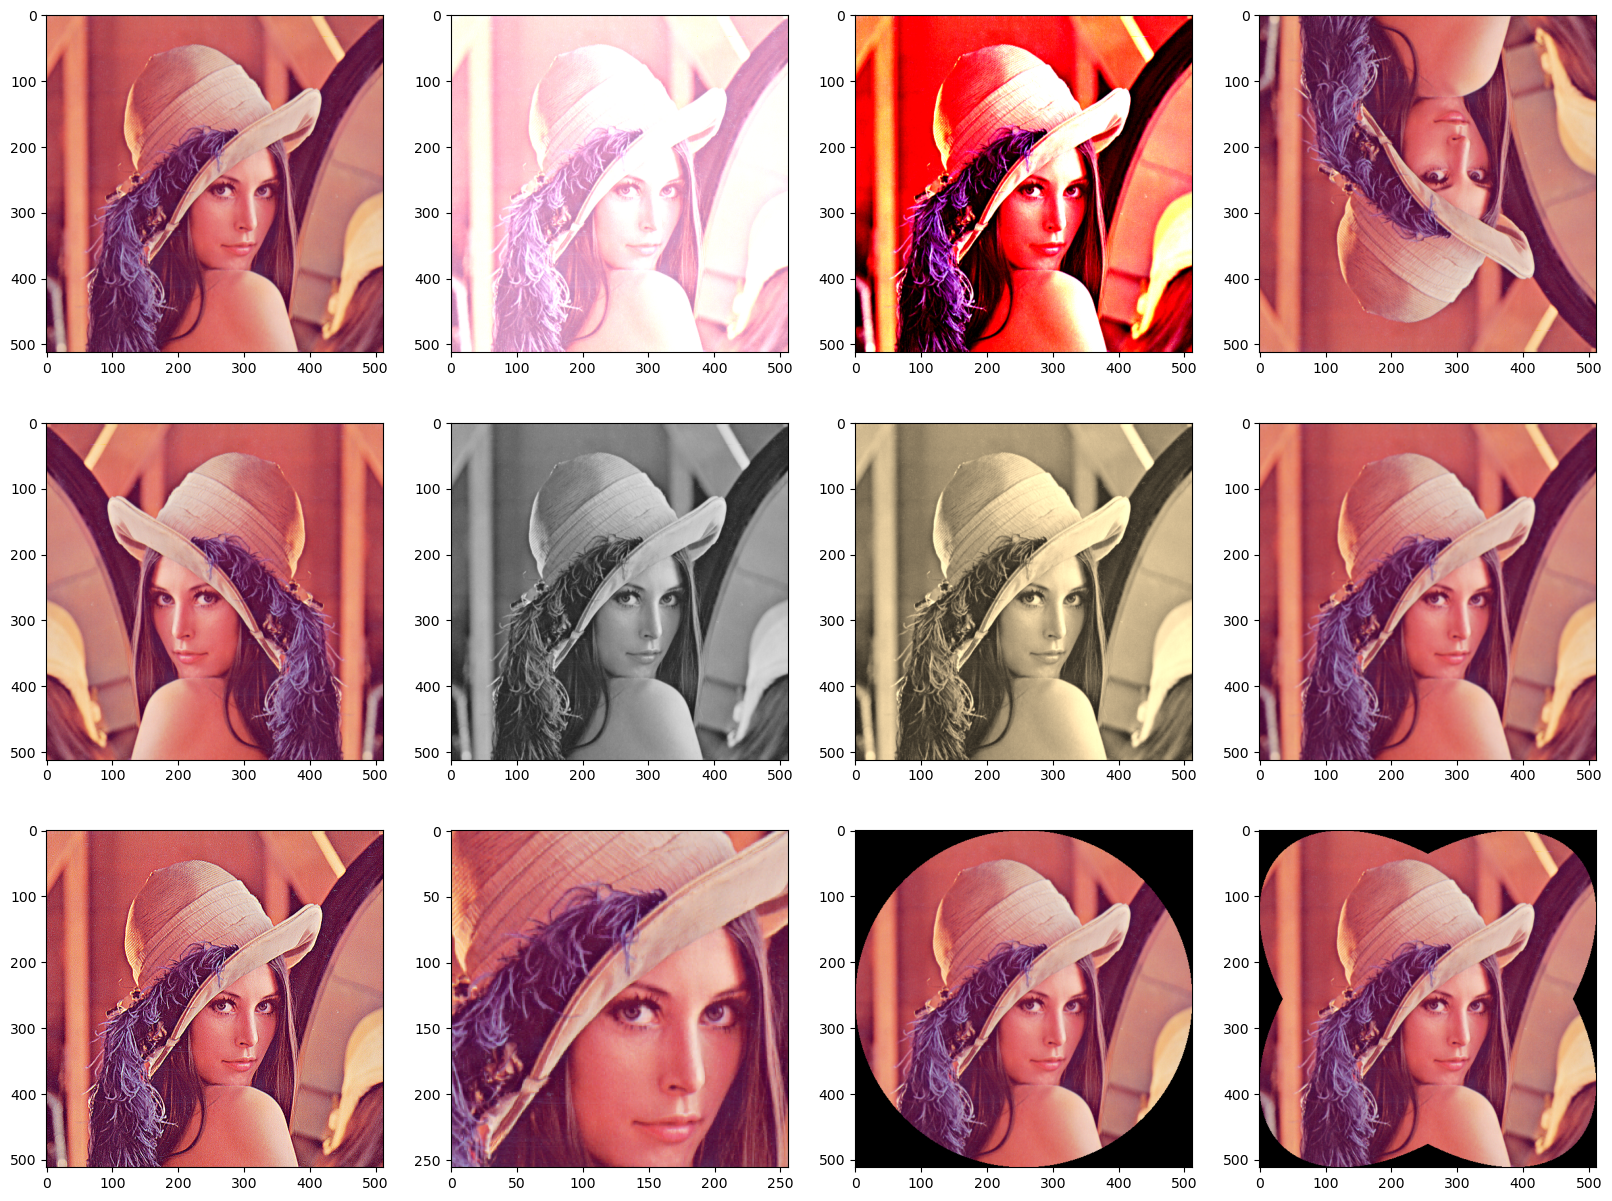

In [513]:
if __name__ == '__main__':
    main()